# Spectral Noise Suppression in Audio Signals Using Custom Windowing and Matrix Transformations

Original Audio Signal


Clean Audio Signal


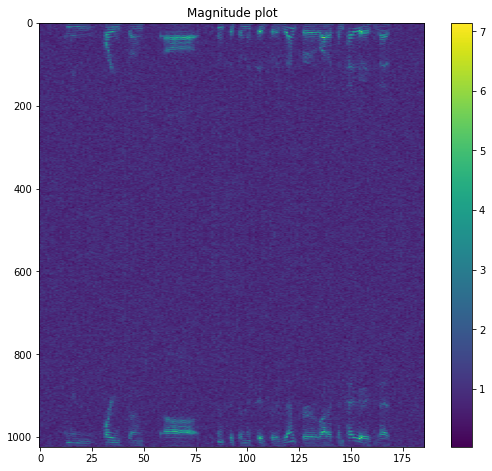

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import scipy.io.wavfile as wav
import librosa
from IPython.display import Audio


def data_hann(x):
    N = len(x)
    hann_window = signal.windows.hann(N)
    windowed_samples = x * hann_window
    return (windowed_samples)


def F_matrix(N):
    Fr = np.zeros((N, N), dtype=float)
    Fi = np.zeros((N, N), dtype=float)
    for f in range(N):
        for n in range(N):
            angle = 2 * np.pi * f * n / N
            Fr[f][n] = np.cos(angle)
            Fi[f][n] = np.sin(angle)

    return Fr, Fi


def audio_signal(Xn, N):
    Xn_t = np.transpose(Xn)
    row_vector = Xn_t.reshape(1,-1)
    row_vector = row_vector[0]

    N_by_2 = int(N/2)

    my_signal = row_vector[0:N_by_2]

    for i in range (N_by_2,len(row_vector)-N,N):
        vec = row_vector[i:i+N_by_2] + row_vector[i+N_by_2:i+N]
        my_signal = np.concatenate((my_signal, vec))

    my_signal = np.concatenate((my_signal, row_vector[-N_by_2:]))

    return my_signal


if __name__ == '__main__':
    data, sr = librosa.load('/content/x.wav', sr=None)
    N = 1024

    Fr, Fi = F_matrix(N)
    F = Fr - 1j * Fi
    F_star = Fr + 1j * Fi

    I = np.matmul(F, F_star) / N

    X = []

    for i in range(0, len(data) - N, int(N / 2)):
        N_samples = data[i:i + N]
        X.append(data_hann(N_samples))

    X = np.array((X))
    X = np.transpose(X)

    Y = np.matmul(F, X)
    magnitude_Y = np.abs(Y)

    # Identified white noise columns from 170 to 186
    # that is the last 16 columns
    
    M = magnitude_Y[:,170:] 
    M = M.sum(axis=1) / len(M[0])
    M = M.reshape(-1, 1)

    suppresed_magnt = magnitude_Y - M
    suppresed_magnt = np.maximum(suppresed_magnt, 0)

    phase_Y = Y / magnitude_Y

    clean_Y = phase_Y * suppresed_magnt

    magnitude_clean_Y = np.abs(clean_Y)

    Xn = (np.matmul(F_star, clean_Y)) / N
    Xn_real = np.real(Xn)

    my_signal = audio_signal(Xn_real, N)
    
    print("Original Audio Signal")
    display(Audio(data=data, rate=sr))

    print("Clean Audio Signal")
    display(Audio(data=my_signal, rate=sr))

    plt.figure(figsize=(9.4, 7.8))
    plt.imshow(magnitude_Y ** 0.5, aspect=0.2)
    plt.title("Magnitude plot")
    plt.colorbar()

    plt.show()
